In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import math
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns


In [4]:
sys.path.append('./../src/')
from aging_tools import calculators, inout, export

In [5]:
out_path = '191101_martinez_nunez'

In [6]:
from access_science_shared import mapper

In [7]:
from access_biology_data import meta, relations, properties



In [8]:
save_images = False

In [9]:
from scipy.stats import spearmanr

In [10]:
p = inout.get_internal_path(
    'datasets/general/resources/publications/martinez_nunez_2017/' +
    'gkw1109_Supplementary_Data/nar-03177-a-2015-File008.xlsx')

In [11]:
df = pd.read_excel(
    p, 
    sheet_name='Supplemental Table 17', 
    skiprows=1)

In [12]:
df = df.rename(columns={
    'symbol': 'symbol_ncbi',
    'log2FcMAP': 'log2FoldChange'
})

In [13]:
df = df[['symbol_ncbi', 'log2FoldChange']]

In [14]:
df = mapper.symbol_2_gene_ncbi(df, 9606, how='median').reset_index()

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
from access_biology_data import meta, relations, properties



In [16]:
pr = properties.genbank_validated_rna(9606)[
    ['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])

In [17]:
from access_science_shared import standardizer

In [18]:
ref_genes=standardizer.reference_genes(9606, 'orp')

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [19]:
m = pd.merge(df, pr)
m = m[m['gene_ncbi'].isin(ref_genes)]

In [20]:
(m['log2FoldChange']<0).sum()

14

In [21]:
(m['log2FoldChange']>0).sum()

46

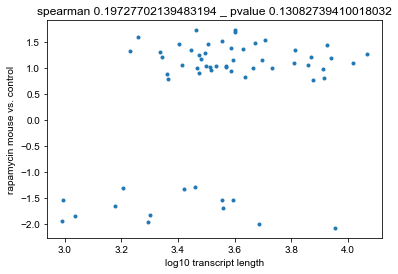

In [22]:

plt.figure()
plt.plot(m['log_length'], m['log2FoldChange'], '.')

r, p = spearmanr(m['log_length'], m['log2FoldChange'])
plt.title('spearman {} _ pvalue {}'.format(r, p))
plt.xlabel('log10 transcript length')
plt.ylabel('rapamycin mouse vs. control')


if save_images:
    export.export_image('{}/scatter.pdf'.format(out_path))

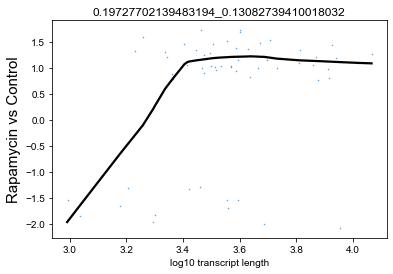

In [23]:
sns.regplot(
    x='log_length',
    y='log2FoldChange',
    data=m,
    scatter_kws={'s': 0.2},
    line_kws={'color': 'black'},
    lowess=True
)



plt.xlabel('log10 transcript length')
plt.ylabel('Rapamycin vs Control', fontsize=15)

plt.title('{}_{}'.format(r, p))

if save_images:
    export.export_image('{}/small_dots_and_regression.pdf'.format(out_path))

In [24]:
m.loc[:, 'is_induced'] = m['log2FoldChange'] > 0

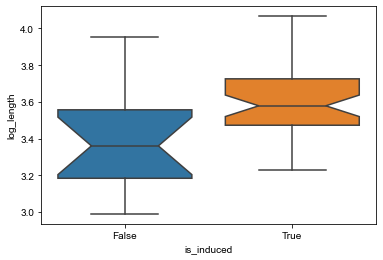

In [25]:
sns.boxplot(x='is_induced', y='log_length', data=m, notch=True)


if save_images:
    export.export_image('{}/boxplots.pdf'.format(out_path))

In [26]:
from scipy.stats import mannwhitneyu

In [27]:
mannwhitneyu(
    m[m['is_induced']==False]['log_length'],
    m[m['is_induced']==True]['log_length'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=164.0, pvalue=0.005910094312329881)

In [28]:
m['is_induced'].value_counts()

True     46
False    14
Name: is_induced, dtype: int64